In [1]:
from typing import Any, Dict, List, Optional, Tuple, Union
import autograd.numpy as np

from numpy import ndarray

import scipy as sp
import autograd as ad
class SNAIL():
    def __init__(
        self,
        EJ:float,
        EC: float,
        beta:float,
        ng: float,
        ncut: int,
        flux:float,
        N:int,
        truncated_dim:int = 6
    ) -> None:
        self.EJ = EJ
        self.EC = EC
        self.beta = beta
        self.ng = ng
        self.ncut = ncut
        self.flux = flux
        self.truncated_dim = truncated_dim
        self.N = N
        self.phi_ex = 2 * np.pi * flux
        self.quantities()
        
    @staticmethod
    def default_params() -> Dict[str, Any]:
        pass
    
    def hilbertdim(self) -> int:
        """Returns Hilbert space dimension"""
        return 2 * self.ncut + 1
    
    def _hamiltonian_diagonal(self) -> ndarray:
        dimension = self.hilbertdim()
        return 4.0 * self.EC * ((np.arange(dimension) - self.ncut)/self.N - self.ng) ** 2
    
    def _hamiltonian_offdiagonal(self) -> ndarray:
        dimension = self.hilbertdim()
        return np.full(shape=(dimension - 1,), fill_value=-self.N * self.EJ / 2.0), np.full(shape=(dimension - 3,), fill_value=-self.beta * np.exp(1j*self.flux) * self.EJ / 2.0)
    
    def _evals_calc(self, evals_count: int) -> ndarray:
        dimension = self.hilbertdim()
        banded_matrix = np.zeros((4, dimension), dtype=np.complex128)
        banded_matrix[0, :] = self._hamiltonian_diagonal()
        banded_matrix[1, 1:],banded_matrix[3, 3:] = self._hamiltonian_offdiagonal()

        evals = sp.linalg.eigvals_banded(
            banded_matrix,
            lower = False,
            select="i",
            select_range=(0, evals_count - 1),
            check_finite=False,
        )
        return evals
    
    def hamiltonian(self) -> ndarray:
        dimension = self.hilbertdim()
        hamiltonian_mat =  np.diag(
            [
                4.0 * self.EC * ((ind - self.ncut)/N - self.ng) ** 2 +1j*0
                for ind in range(dimension)
            ]
        )
        ind = np.arange(dimension - 1)
        hamiltonian_mat[ind, ind + 1] = -self.N * self.EJ / 2.0
        hamiltonian_mat[ind + 1, ind] = -self.N * self.EJ / 2.0
        ind = np.arange(dimension - 3)
        hamiltonian_mat[ind, ind + 3] = -self.beta * np.exp(1j*self.flux * 2*np.pi) * self.EJ / 2.0
        hamiltonian_mat[ind + 3, ind] = -self.beta * np.exp(-1j*self.flux * 2*np.pi) * self.EJ / 2.0
        return hamiltonian_mat
    
    def _U_s(self,phi): 
            return (-self.beta*np.cos(phi-self.phi_ex)-3*np.cos((phi)/3))
        
    def plot_potential(self):
        phi = np.linspace(-1.5,1.5,1000)*2*np.pi
        plt.plot(phi/2/np.pi,self._U_s(phi))
        
    def quantities(self):
        beta = self.beta
        phi_ex = self.phi_ex
        EJ = self.EJ
        EC = self.EC

        phi_min = sp.optimize.minimize(self._U_s,0).x
        self.phi_min = phi_min[0]
        # potential expansion around minimum
        firstd = ad.grad(self._U_s)
        secondd = ad.grad(firstd)
        thirdd = ad.grad(secondd)
        fourd = ad.grad(thirdd)
        fived = ad.grad(fourd)
        sixd = ad.grad(fived)
        sevend = ad.grad(sixd)
        eightd = ad.grad(sevend)
        c2 = secondd(phi_min[0])
        c3 = thirdd(phi_min[0])
        c4 = fourd(phi_min[0])
        c5 = fived(phi_min[0])
        c6 = sixd(phi_min[0])
        c7 = sevend(phi_min[0])
        c8 = eightd(phi_min[0])
        self.bare_omegas = np.sqrt(8*c2*EJ*EC)
        self.phi_zpf = np.power(2*EC/EJ/c2,1/4)
        self.g2 = EJ*self.phi_zpf**2*c2/2
        self.g3 = EJ*self.phi_zpf**3*c3/3/2
        self.g4 = EJ*self.phi_zpf**4*c4/4/3/2
        self.g5 = EJ*self.phi_zpf**5*c5/5/4/3/2
        self.g6 = EJ*self.phi_zpf**6*c6/6/5/4/3/2
        self.g7 = EJ*self.phi_zpf**7*c7/7/6/5/4/3/2
        self.g8 = EJ*self.phi_zpf**8*c8/8/7/6/5/4/3/2
        H,op = self.spectrum_charge()
        self.omegas = H[1,1]
        self.anh = H[2,2]-2*H[1,1]
        
    def spectrum_charge(self):
        dimension = self.hilbertdim()
        H = self.hamiltonian()
        energy,U = np.linalg.eigh(H)
        U_dag = np.transpose(U.conjugate())
        energy = np.real(energy-energy[0]*np.ones(len(energy)))
        charge_op = hamiltonian_mat =  np.diag(
            [
                (ind - self.ncut)/N - self.ng
                for ind in range(dimension)
            ]
        )
        charge = U_dag@charge_op@U
        H = np.real(U_dag@H@U)
        return (H - H[0][0]*np.identity(dimension))[:self.truncated_dim,:self.truncated_dim],charge[:self.truncated_dim,:self.truncated_dim]
    
class SNAIL_sweep(SNAIL):
    def __init__(self, snail_object ):
        self.EJ = snail_object.EJ
        self.EC = snail_object.EC
        self.beta = snail_object.beta
        self.ng = snail_object.ng
        self.ncut = snail_object.ncut
        self.flux = snail_object.flux
        self.truncated_dim = snail_object.truncated_dim
        self.N = snail_object.N
        self.fluxs = np.linspace(0.4,0.5,10)
        self.g3s = []
        self.g4s = []
        self.g5s = []
        self.g6s = []
        self.g7s = []
        self.g8s = []
        self.bare_omegass = []
        self.omegass = []
        self.anhs = []
        self.quantities_sweep()
        
    def quantities_sweep(self):
        
        for flux in self.fluxs:
            snail_back = SNAIL(self.EJ,self.EC,self.beta,self.ng,self.ncut,flux,self.N)
            (self.g3s).append(snail_back.g3)
            (self.g4s).append(snail_back.g4)
            (self.g5s).append(snail_back.g5)
            (self.g6s).append(snail_back.g6)
            (self.g7s).append(snail_back.g7)
            (self.g8s).append(snail_back.g8)
            (self.bare_omegass).append(snail_back.bare_omegas)
            H,op = snail_back.spectrum_charge()
            omegass = H[1,1]
            anh = H[2,2]-2*H[1,1]
            (self.omegass).append(omegass)
            (self.anhs).append(anh)
    

In [24]:
class Cavity():
    def __init__(
        self,
        cavity_freq:float,
        g_int:float,
        truncated_dim:int = 10
    ) -> None:
        self.cavity_freq = cavity_freq
        self.g_int = g_int
        self.truncated_dim = truncated_dim
        
    def annihilation(self):
        return np.diag(np.sqrt(np.arange(1,self.truncated_dim)),1)
    
    def creation(self):
        return np.diag(np.sqrt(np.arange(1,self.truncated_dim)),-1)
    
    def hamiltonian(self):
        return self.cavity_freq*self.creation()@self.annihilation(), 1j*(self.creation() - self.annihilation())

In [25]:
class SNAILC(SNAIL):
    def __init__(self,
        snail_object,
        cavity_object,
        truncated_dim = 100
    ) -> None:
        self.snail = snail_object
        self.cavity = cavity_object
        self.hamiltonian()
        self.truncated_dim = truncated_dim
    

    def hamiltonian(self):
        snail = self.snail
        cavity = self.cavity
        sdim = snail.truncated_dim
        cdim = cavity.truncated_dim
        Hs, charge_op = snail.spectrum_charge()
        
        Hc, Vc = cavity.hamiltonian()
        Ic = np.identity(cdim)
        Is = np.identity(sdim)
        Hs = np.kron(Hs,Ic)
        Hc = np.kron(Is,Hc)
        self.charge_op = np.kron(charge_op,Ic)
        H_int = cavity.g_int*np.kron(charge_op,Vc)*2*((2*snail.EC/snail.EJ)**0.25)
        c2 = snail.bare_omegas**2/8/snail.EC/snail.EJ
        self.g_intr = cavity.g_int*2*((2*snail.EC/snail.EJ/c2)**0.25)
        H = Hs + Hc + H_int
        return H
    
    def parameters(self):
        H = self.hamiltonian()
        snail = self.snail
        cavity = self.cavity
        energy,U = np.linalg.eigh(H)
        U_dag = np.transpose(U.conjugate())
     
        self.dressed_charge = U_dag@self.charge_op@U
        self.dressed_charge = self.dressed_charge[:self.truncated_dim,:self.truncated_dim]
        self.dressed_H = U_dag@H@U
        self.dressed_H = (self.dressed_H - self.dressed_H[0][0]*np.identity(len(self.dressed_H)))
        self.dressed_H = self.dressed_H[:self.truncated_dim,:self.truncated_dim]
        
        energy = np.real(energy-energy[0]*np.ones(len(energy)))
        index = np.argmin(np.abs(energy-cavity.cavity_freq*np.ones(len(energy))))
        omega_cp = energy[index]
        
        index = np.argmin(np.abs(energy-snail.omegas*np.ones(len(energy))))
        omega_sp = energy[index]
        index = np.argmin(np.abs(energy-2*cavity.cavity_freq*np.ones(len(energy))))
        selfkerr = energy[index] - 2*omega_cp
        
        index = np.argmin(np.abs(energy-cavity.cavity_freq*np.ones(len(energy))-snail.omegas))
        starkshift = energy[index] - cavity.cavity_freq - omega_sp
        
        index = np.argmin(np.abs(energy-2*cavity.cavity_freq*np.ones(len(energy))-snail.omegas))
        sc_crosskerr = energy[index]  - 2*cavity.cavity_freq - omega_sp - 2*starkshift
        
        return omega_cp, starkshift, selfkerr, sc_crosskerr
    
class SNAILC_sweep(SNAILC):
    def __init__(self, snailc_object,  ):
        self.fluxs = np.linspace(0.4,0.5,10)
        self.snail = snailc_object.snail
        self.cavity = snailc_object.cavity   
        self.selfkers = []
        self.starkshifts = []
        self.sc_crosskerrs = []
        self.omegac = []
        self.g_ints = []
        self.apps = []
        
    def quantities_sweep(self):
        cavity = self.cavity
        snail = self.snail
        for flux in self.fluxs:
            snail_back = SNAIL(snail.EJ,snail.EC,snail.beta,snail.ng,snail.ncut,flux,snail.N,snail.truncated_dim)
            snailc_back = SNAILC(snail_back, self.cavity)
            omega_c, starkshift, selfkerr, sc_crosskerr = snailc_back.parameters()
            self.omegac.append(omega_c)
            self.starkshifts.append(starkshift)
            self.selfkers.append(selfkerr)
            self.sc_crosskerrs.append(sc_crosskerr)
            self.g_ints.append(snailc_back.g_intr)
            self.apps.append(cavity.cavity_freq+ snailc_back.g_intr**2/(cavity.cavity_freq - snail_back.bare_omegas)) 
        return self.omegac, self.starkshifts, self.selfkers, self.sc_crosskerrs, self.apps

In [26]:
class SNAILCC(SNAIL):
    def __init__(self,
        snail_object,
        cavity1,
        cavity2,
    ) -> None:
        self.snail = snail_object
        self.cavity1 = cavity1
        self.cavity2 = cavity2
        self.snailc1 = SNAILC(snail_object, cavity1)
        self.snailc2 = SNAILC(snail_object, cavity2)
        
    def hamiltonian(self):
        snail = self.snail
        self.snailc1_paras = self.snailc1.parameters()
        self.snailc2_paras = self.snailc2.parameters()
        snailc1 = self.snailc1
        cavity2 = self.cavity2
        scdim = snailc1.truncated_dim
        c2dim = cavity2.truncated_dim
        Hsc = snailc1.dressed_H
        dressed_charge = snailc1.dressed_charge
        
        Hc, Vc = cavity2.hamiltonian()
        Ic = np.identity(c2dim)
        Isc = np.identity(scdim)
        Hsc = np.kron(Hsc,Ic)
        Hc = np.kron(Isc,Hc)
        H_int = cavity2.g_int*np.kron(dressed_charge,Vc)*2*((2*snail.EC/snail.EJ)**0.25)
        c2 = snail.bare_omegas**2/8/snail.EC/snail.EJ
        self.g_intr = cavity2.g_int*2*((2*snail.EC/snail.EJ/c2)**0.25)
        H = Hsc + Hc + H_int
        return H
    
    def parameters(self):
        cavity1 = self.cavity1
        cavity2 = self.cavity2
        H = self.hamiltonian()
        energy,dressed_states = np.linalg.eigh(H)
        energy = np.real(energy-energy[0]*np.ones(len(energy)))
        
        index = np.argmin(np.abs(energy-cavity1.cavity_freq*np.ones(len(energy))))
        omega_cp1 = energy[index]
        
        index = np.argmin(np.abs(energy-cavity2.cavity_freq*np.ones(len(energy))))
        omega_cp2 = energy[index]
        
        index = np.argmin(np.abs(energy-omega_cp2-omega_cp1))
        cross_kerr = energy[index] - omega_cp1 - omega_cp2
        return cross_kerr,self.snailc1_paras,self.snailc2_paras
    
class SNAILCC_sweep(SNAILCC):
    def __init__(self, snailcc_object,  ):
        self.fluxs = np.linspace(0.4,0.5,10)
        self.snail = snailcc_object.snail
        self.cavity1 = snailcc_object.cavity1
        self.cavity2 = snailcc_object.cavity2
        
        self.crosskerr = []
        
        self.selfkers1 = []
        self.starkshifts1 = []
        self.sc_crosskerrs1 = []
        self.omegac1 = []
        self.g_ints1 = []
        self.apps1 = []
        
        self.selfkers2 = []
        self.starkshifts2 = []
        self.sc_crosskerrs2 = []
        self.omegac2 = []
        self.g_ints2 = []
        self.apps2 = []
        
    def quantities_sweep(self):
        snail = self.snail
        
        cavity1 = self.cavity1
        cavity2 = self.cavity2
        for flux in self.fluxs:
            snail_back = SNAIL(snail.EJ,snail.EC,snail.beta,snail.ng,snail.ncut,flux,snail.N,snail.truncated_dim)
            snailcc_back = SNAILCC(snail_back, cavity1, cavity2)
            snailc1 = snailcc_back.snailc1
            snailc2 = snailcc_back.snailc2
            cross_kerr, snailc1_paras, snailc2_paras = snailcc_back.parameters()
            self.crosskerr.append(cross_kerr)
            
            self.omegac1.append(snailc1_paras[0])
            self.starkshifts1.append(snailc1_paras[1])
            self.selfkers1.append(snailc1_paras[2])
            self.sc_crosskerrs1.append(snailc1_paras[3])
            self.g_ints1.append(snailc1.g_intr)
            self.apps1.append(cavity1.cavity_freq + snailc1.g_intr**2/(cavity1.cavity_freq - snail_back.bare_omegas)) 
            snailc1_paras = [self.omegac1, self.starkshifts1, self.selfkers1, self.sc_crosskerrs1, self.g_ints1, self.apps1]
            
            self.omegac2.append(snailc2_paras[0])
            self.starkshifts2.append(snailc2_paras[1])
            self.selfkers2.append(snailc2_paras[2])
            self.sc_crosskerrs2.append(snailc2_paras[3])
            self.g_ints2.append(snailc2.g_intr)
            self.apps2.append(cavity2.cavity_freq + snailc2.g_intr**2/(cavity2.cavity_freq - snail_back.bare_omegas))
            snailc2_paras = [self.omegac2, self.starkshifts2, self.selfkers2, self.sc_crosskerrs2, self.g_ints2, self.apps2]
        return self.crosskerr, snailc1_paras, snailc2_paras

In [27]:
from matplotlib import pyplot as plt

In [28]:
EJ = 90*2*np.pi
EC = 0.177*2*np.pi
beta = 0.33
ng = 0
ncut = 300
flux = 0.48
N = 3
dims = 30

# truncated_dim:int = 6
snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)

omega_c1 = 7*2*np.pi
g_int1 = 0.15*2*np.pi
dimc1 = 10
cavity1 = Cavity(omega_c1,g_int1,dimc1)

omega_c2 = 5.1*2*np.pi
g_int2 = 0.15*2*np.pi
dimc2 = 10
cavity2 = Cavity(omega_c2,g_int2,dimc2)

snailcc = SNAILCC(snail,cavity1,cavity2)
snailcc_sweep = SNAILCC_sweep(snailcc)

In [29]:
snailc = SNAILC(snail,cavity2,)

In [30]:
crosskerr,snailc1_paras,snailc2_paras = snailcc_sweep.quantities_sweep()

In [31]:
omega_cs1,starkshifts1,selfkerrs1,sc_crosskerrs1,g_ints1,apps1 = snailc1_paras
omega_cs2,starkshifts2,selfkerrs2,sc_crosskerrs2,g_ints2,apps2 = snailc2_paras

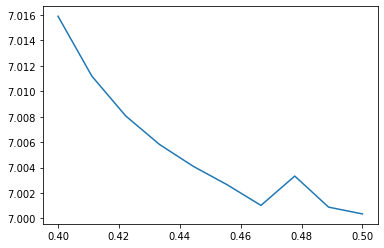

In [32]:
# plt.plot(snailc_sweep.fluxs[0:], (np.array(apps)/2/np.pi)[0:],label = 'app')
plt.plot(snailcc_sweep.fluxs,(np.array (omega_cs1)/2/np.pi),label = 'exact')

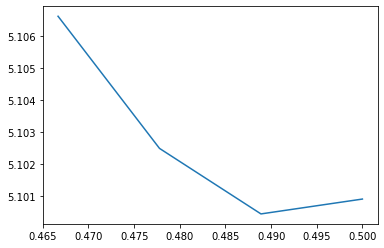

In [33]:
# plt.plot(snailc_sweep.fluxs[0:], (np.array(apps)/2/np.pi)[0:],label = 'app')
plt.plot(snailcc_sweep.fluxs[6:],(np.array (omega_cs2)/2/np.pi)[6:],label = 'exact')

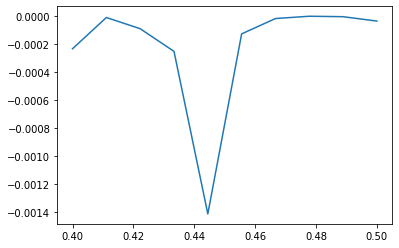

In [34]:
plt.plot(snailcc_sweep.fluxs, np.array(crosskerr)/2/np.pi)
# plt.ylim(-1e-4,1e-4)

(-1e-05, 1e-05)

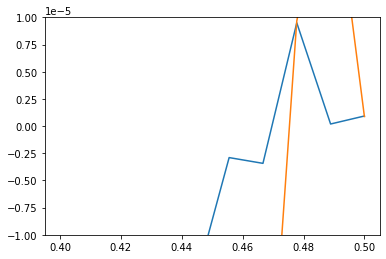

In [35]:
plt.plot(snailcc_sweep.fluxs, np.array(selfkerrs1)/2/np.pi)
plt.plot(snailcc_sweep.fluxs, np.array(selfkerrs2)/2/np.pi)
plt.ylim(-1e-5,1e-5)

(-0.001, 0.001)

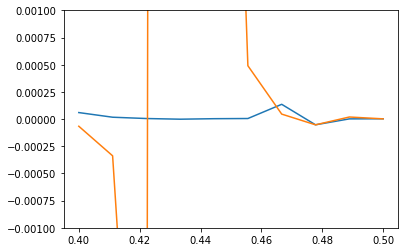

In [22]:
plt.plot(snailcc_sweep.fluxs, np.array(sc_crosskerrs1)/2/np.pi)
plt.plot(snailcc_sweep.fluxs, np.array(sc_crosskerrs2)/2/np.pi)
plt.ylim(-1e-3,1e-3)

In [716]:
snail_sweep = SNAIL_sweep(snail)

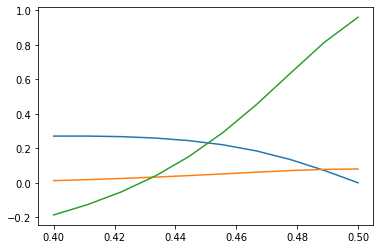

In [717]:

plt.plot(snail_sweep.fluxs, np.array(snail_sweep.g3s)/2/np.pi )
plt.plot(snail_sweep.fluxs, np.array(snail_sweep.g4s)/2/np.pi )
# plt.plot(snail_sweep.fluxs, -60*np.array(snail_sweep.g5s)/2/np.pi )
# plt.plot(snail_sweep.fluxs, np.array(snail_sweep.anhs)/2/np.pi )
plt.plot(snail_sweep.fluxs, 12*(np.array(snail_sweep.g4s)-5*np.array(snail_sweep.g3s)/np.array(snail_sweep.bare_omegass))/2/np.pi )

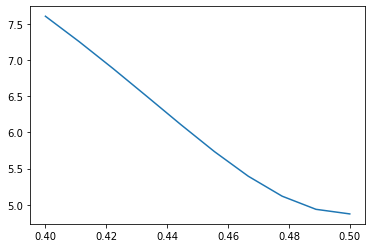

In [695]:
plt.plot(snail_sweep.fluxs, np.array(snail_sweep.omegass)/2/np.pi )